In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from time import time
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [15]:
# df = pd.read_csv("../first500_AAPL_merged.csv",index_col="day_date")
df = pd.read_csv("../kaggle_data/CompanyValues.csv",index_col="day_date")

In [16]:
df.drop(columns=['volume','ticker_symbol'],inplace=True)
value =df[(df["day_date"]>="2015-01-01") & (df["day_date"]<="2019-12-31")]

df = df[1563:]
# print("---dataframe head---")
print(df.head())

            close_value  open_value  high_value  low_value
day_date                                                  
2020-05-29       317.94      319.25      321.15     316.47
2020-05-28       318.25      316.77      323.44     315.63
2020-05-27       318.11      316.14      318.71     313.09
2020-05-26       316.73      323.50      324.24     316.50
2020-05-22       318.89      315.77      319.23     315.35


In [17]:
print("--scaling data---")
data = sc.fit_transform(df)

--scaling data---


In [18]:
train_ind = int(0.6*len(df))
val_ind = train_ind + int(0.2*len(df))

train = data[:train_ind]
val = data[train_ind:val_ind]
test = data[val_ind:]

print("--shapes--")
print("train,test,val",train.shape, test.shape, val.shape)

--shapes--
train,test,val (10516, 4) (3507, 4) (3505, 4)


In [19]:
xtrain,ytrain,xval,yval,xtest,ytest = train[:,:4],train[:,1],val[:,:4],val[:,1],test[:,:4],test[:,1]

lookback = 60
n_features = 4
train_len = len(xtrain) - lookback
test_len = len(xtest) - lookback
val_len = len(xval) - lookback

x_train = np.zeros((train_len, lookback, n_features))
y_train = np.zeros((train_len))
for i in range(train_len):
    ytemp = i+lookback
    x_train[i] = xtrain[i:ytemp]
    y_train[i] = ytrain[ytemp]
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_test = np.zeros((test_len, lookback, n_features))
y_test = np.zeros((test_len))
for i in range(test_len):
    ytemp = i+lookback
    x_test[i] = xtest[i:ytemp]
    y_test[i] = ytest[ytemp]
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_val = np.zeros((val_len, lookback, n_features))
y_val = np.zeros((val_len))
for i in range(val_len):
    ytemp = i+lookback
    x_val[i] = xval[i:ytemp]
    y_val[i] = yval[ytemp]
print("x_val", x_val.shape)
print("y_val", y_val.shape)

x_train (10456, 60, 4)
y_train (10456,)
x_test (3447, 60, 4)
y_test (3447,)
x_val (3445, 60, 4)
y_val (3445,)


In [10]:
x_train

array([[[1.        , 0.99191246, 0.99804384, 1.        ],
        [0.98593688, 0.98871823, 0.99136594, 0.97085141],
        [0.97458075, 1.        , 1.        , 0.99050976],
        ...,
        [0.56014789, 0.56442844, 0.55359191, 0.56697397],
        [0.54278357, 0.55620497, 0.55541315, 0.55809382],
        [0.56034597, 0.55926329, 0.56802698, 0.56832972]],

       [[0.98593688, 0.98871823, 0.99136594, 0.97085141],
        [0.97458075, 1.        , 1.        , 0.99050976],
        [0.97530701, 0.95718363, 0.973086  , 0.96732646],
        ...,
        [0.54278357, 0.55620497, 0.55541315, 0.55809382],
        [0.56034597, 0.55926329, 0.56802698, 0.56832972],
        [0.56001585, 0.55498165, 0.5515683 , 0.55511117]],

       [[0.97458075, 1.        , 1.        , 0.99050976],
        [0.97530701, 0.95718363, 0.973086  , 0.96732646],
        [0.93806946, 0.95630012, 0.93875211, 0.95525827],
        ...,
        [0.56034597, 0.55926329, 0.56802698, 0.56832972],
        [0.56001585, 0.554981

In [20]:
model = Sequential()
model.add(LSTM(600,input_shape = (lookback, n_features), return_sequences=True))
model.add(LSTM(700))
model.add(Dropout(0.15))
model.add(Dense(1))
print(model.summary())

model.compile(loss = 'mse', optimizer = 'adam')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')

start = time()
print("start:",0)
history = model.fit(x_train,y_train, epochs = 10, batch_size=32,
# history = model.fit(x_train,y_train, epochs = 100, batch_size=32,
          validation_data=(x_val,y_val),verbose = 1,
          shuffle = False, callbacks=[earlystop])
print("end:",time()-start)

model.save("./models/model-vadercase6.h5")
loss = history.history

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 600)           1452000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 700)               3642800   
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 701       
Total params: 5,095,501
Trainable params: 5,095,501
Non-trainable params: 0
_________________________________________________________________
None
start: 0
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 

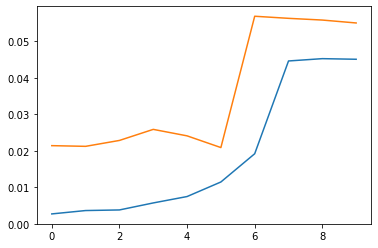

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
r2_score: -1143226117.6792724


In [21]:
plt.plot(loss['loss'])
plt.plot(loss['val_loss'])
plt.savefig("./loss-vadercase6.jpg")
plt.show()
y_pred = model.predict(x_test)
print("r2_score:",r2_score(y_pred,y_test))

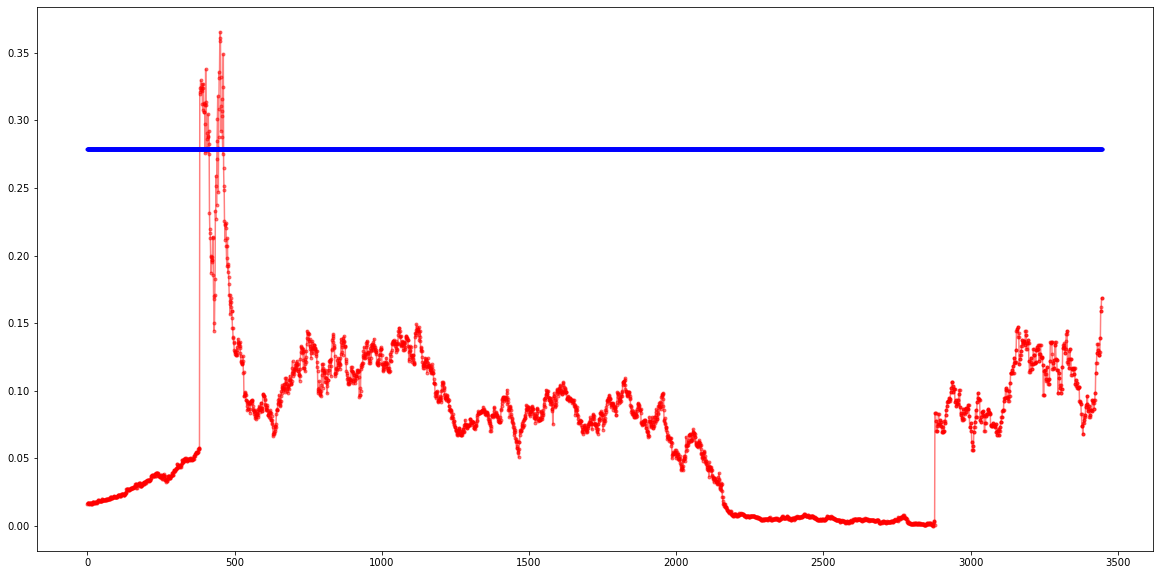

In [22]:
plt.figure(figsize=(20,10))
plt.plot( y_test, '.-', color='red', label='Real values', alpha=0.5)
plt.plot( y_pred, '.-', color='blue', label='Predicted values', alpha=1)
plt.savefig("./result-vadercase6.jpg")
plt.show()

